# Supervised learning
Now that we loaded and explored the data, let's start with building our first models.
In this chapter, we'll only look at a very simple model, the k-Nearest Neighbors classifier.
It's easy to understand and has all the ingredients you need to know for a machine learning workflow.
In chapter TODO, we'll discuss many other models.

```{margin}
The interface of all the models is the same in scikit-learn,
so you can easily switch out the code for another model now if you like.
```

## Classification with scikit-learn
We will start with the simple and well-behaved breast cancer dataset:

In [1]:
from sklearn.datasets import load_breast_cancer
# specifying "as_frame=True" returns the data as a dataframe in addition to a numpy array
cancer = load_breast_cancer(as_frame=True)
cancer_df = cancer.frame
cancer_df.shape

(569, 31)

In [2]:
cancer_df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

### Training and Test set

First, we split our data into a training and a test set. TODO is this the first mention?
This is a critical component of any supervised learning workflow. As you know, our goal is to build a model that generalizes well, i.e. that predicts well on data that is has not seen before.
We could use all our data to built a model, but then we would have no way to know whether our model really works, i.e. how accurately it predicts on new data.
The easiest way to measure the generalization capability of our model is to apply it to some hold-out data, that was not used to build the model, but for which we have the correct answer.
Then we can make predictions on our hold-out set and compare them against the known answers, to measure how well the model performs.
So we need disjoint datasets: one to build the model, usually called the training set, and another, to validate model accuracy, usually called the test set.

![:scale 60%](images/train_test_set_2d_classification.png)


A very common way to generate the test set is to split the data randomly, and there's function in scikit-learn to help you with that, called ``train_test_split``:

In [3]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(cancer_df)

This function splits off 25% of the rows randomly to use as test set:

In [4]:
data_train.shape

(426, 31)

In [5]:
data_test.shape

(143, 31)

We can controll the size of the test set by changing the ``test_size`` parameter to either a number of samples or a percentage of the training data. But 75% of the data is usually a good rule of thumb. As the process is random, you will get a different split of the data every time you run this line of code. For the purposes of this book, we'll make the split deterministic by providing a fixed random seed, which can be an arbitrary integer:

In [6]:
data_train, data_test = train_test_split(cancer_df, random_state=42)

This way, the results of our analysis later will be the same every time as when you run the code, and the won't change if you run the code again.

```{margin} Setting random seeds
In a real analysis, there are pros and cons to setting this seed. Generally, your results should be independent of how you split your data. If the quality of your model depends strongly of how you split your data, then your model is probably not very robust and you might not want to use it. If you keep the seed fixed the whole time, you might not know whether you got lucky (or unlucky) with your particular split, so it might be good to either not set the seed, or run with multiple different seeds. On the other hand, if you didn't set the seed, and you get a surprising result, then it might be very hard for someone else (or even for yourself) to reproduce your results as you have no record of how the data was split.
```

There are actually quite some assumptions made when splitting the data randomly, and we will discuss them in more detail in chapter TODO.

Now, we separate the features from the target, which is required for using scikit-learn.
The easiest way to do that is to use the ``drop`` method of the DataFrame:

In [7]:
X_train = data_train.drop(columns='target')
y_train = data_train.target
X_test = data_test.drop(columns='target')
y_test = data_test.target

Here, we're calling the features 'X' and the targets 'y', a common convention in scikit-learn and machine learning more broadly.
```{margin}
The 'X' is capital because it refers to a matrix, a two-dimensional array, while 'y' is typically a column vector or one-dimensional array. Using capital letters for matrices and lower case letters for vectors is a common practice in linear algebra.
```

````{Note}
Alternatively, we could have first split off the target column and then separated the data into training and test set, like so:
    ```{python}
    X = data.drop(columns='target')
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    ```
This is one line shorter and the more common idiom, but maybe a bit harder to read and remember.
````  

Now we're all set and can get started building our first models with scikit-learn!

## Nearest Neighbors Classification


The first algorithm we'll use is Nearest Neighbors classification. It's not commonly used in practice as it doesn't scale that well to datasets with many samples, but it's often quite accurate and very easy to understand.
For illustration purposes (as it is easier to draw in two dimensions), let us first consider just two features of the breast cancer dataset that we found informative before, 'mean compactness' and 'worst concave points':

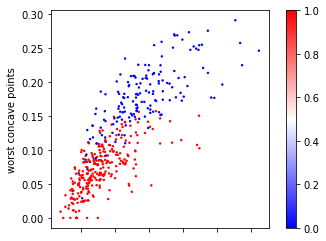

In [8]:
import matplotlib.pyplot as plt
# the return value is the axes that was created for the plot
ax = X_train.plot.scatter(x='mean compactness', y='worst concave points',
                     # use the target to color points
                     # use the blue-white-red colormap
                     c=y_train, colormap='bwr', s=2)
# TODO why is there no xlabel
# We set the aspect ratio to equal to faithfully represent distances between points.
ax.set_aspect("equal")

Now let's look at some of the samples from the test set, drawn as black stars:

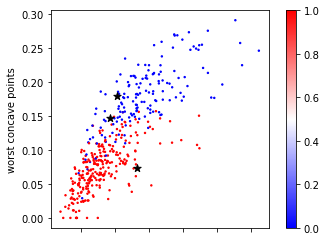

In [9]:
ax = X_train.plot.scatter(x='mean compactness', y='worst concave points',
                         c=y_train, colormap='bwr', s=2)
# Take just a couple of test points:
X_try = X_test.iloc[[1, 3, 11], :]   
# plot into the same axes
X_try.plot.scatter(x='mean compactness', y='worst concave points', c='k', marker="*", s=60, ax=ax);
ax.set_aspect("equal")

Looking at this two dimensional scatter plot, we can probably make a reasonable guess that the most likely label for the top one is blue, as all the surrounding points are blue, while the most likely label for the bottom point is red, because all the surrounding points are read. It's maybe a little bit less clear what label to assign to the point in the center.

Nearest Neighbors, as the name suggest, formalizes this intuition and simply applies the label of the closest point in the training dataset, as illustrated in Figure TODO.




(0.06, 0.2)

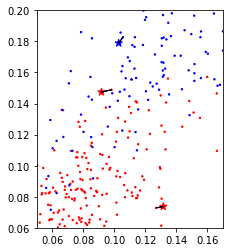

In [10]:
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def plot_n_neighbors(X_train, y_train, X_test, n_neighbors=1):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)

    #plt.figure(figsize=(10, 10))
    plt.gca().set_aspect("equal")
    training_points = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=2)    

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X_train[neighbor, 0] - x[0],
                    X_train[neighbor, 1] - x[1], head_width=0, fc='k', ec='k', width=0.0001)

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    test_points = plt.scatter(X_test[:, 0], X_test[:, 1], c=clf.predict(X_test), marker="*", cmap='bwr', s=60)
    return plt.gca()
    
ax = plot_n_neighbors(X_train[['mean compactness', 'worst concave points']],
                      y_train, X_try[['mean compactness', 'worst concave points']])
ax.set_xlim(0.05, 0.17)
ax.set_ylim(0.06, 0.2)


```{admonition} Mathematical Background
Formally, you could define the prediction of nearest neighbors based on a dataset $(x_i, y_i), i=1,..,n$ as:
$$f(x) = y_i, i = \text{argmin}_j || x_j - x||$$
```

In a simple extension of Nearest neighbors, we could look at a number of neighbors, say 3 or 5, and determine the majority class among them.
This is known as k-Nearest Neighbors, where the k stands for the number of neighbors to consider. What number to use is up to the user to decide.
Here is an example using just the two features from a above of using the five nearest neighbors on the same three points:

(0.06, 0.2)

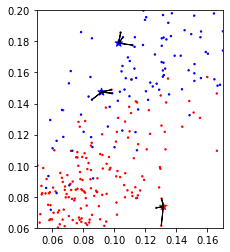

In [11]:
ax = plot_n_neighbors(X_train[['mean compactness', 'worst concave points']],
                      y_train, X_try[['mean compactness', 'worst concave points']],
                      n_neighbors=3)
ax.set_xlim(0.05, 0.17)
ax.set_ylim(0.06, 0.2)

We can see that for one of the datapoints, the predicted label switches from red to blue, as the closest neighbor in the training set is red, but out of the three closest neighbors, two are blue.

Now let's build a model using scikit-learn and evaluate it on the test set.
All machine learning models in scikit-learn are implemented as Python classes, all with the same interface.
The Python class encapsulates both the training and the prediction procedure and stores the model estimated from the data.


In [12]:
# We start by importing the KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
# Then we instantiate the class.
# This is when we specify user-specified parameters like the number of neighbors
# Here, we set the number of neighbors to one
knn = KNeighborsClassifier(n_neighbors=1)

All models in scikit-learn have a ``fit`` method that takes as arguments the training data ``X_train`` (which does not contain the target) and for supervised problems also the training target ``y_train``, which is usually a single column:

In [13]:
X_train.shape, y_train.shape

((426, 30), (426,))

We could just use a subset of the features we looked at before, but now let's use all of them, i.e. all 30 columns.
The `fit` method does the actual learning and stores the result in the object itself (that we called knn here). The return value of the ``fit`` method is `self`, meaning it returns the knn object.
In the case of k Nearest Neighbors, the `fit` method simply stores the training data.

```{margin}
TODO pandas disclaimer again
```

In [14]:
# because fit returns self, Jupyter renders a representation of the object
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

All done building your first model! That was easy, right?
But no, the question is whether our model actually learned anything. We can measure that by looking at the predictions on the test set.
All classification and regression models in scikit-learn have a ``predict`` method that takes the test data ``X_test`` and returns a prediction for each row:

In [15]:
X_test.shape

(143, 30)

In [16]:
y_pred = knn.predict(X_test)
y_pred.shape

(143,)

Now we can compare these predictions according to our model to the true outcomes that we have stored in ``y_test``.
For a classification problem, a common metric (more on this in chapter TODO) is accuracy, which is the fraction of correctly predicted samples.
While there's an ``accuracy_score`` function in scikit-learn, we can also easily compute it using pandas or numpy using equality:

In [17]:
(y_pred == y_test).mean()

0.9300699300699301

What this tells us is that the predictions made by your model are 93% accurate, i.e. for 93% of the samples, our simple one Nearest Neighbor, using all 30 features.
Because computing evaluations is so common, there's a shortcut in scikit-learn that makes the prediction and computes the accuracy for you, the ``score`` method:

In [18]:
print("accuracy: ", knn.score(X_test, y_test))

accuracy:  0.9300699300699301


One thing to keep in mind is that accuracy can be very hard to interpret if one of the two classes is much more frequent than the other one.
This dataset is somewhat unbalanced, as you might recall:

In [19]:
y_test.value_counts(normalize=True)

1    0.622378
0    0.377622
Name: target, dtype: float64

That means that if a model predicted 1 (i.e. benign) for all samples, it would be 62.2% accurate. Clearly our model is doing much better than that.

Now, let's to the same again, this time with using five nearest neighbors:

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("accuracy: ", knn.score(X_test, y_test))

accuracy:  0.965034965034965


```{margin}
Tuning options are known as hyper-parameters, as opposed to parameters, as in statistics, the part of the model that's estimated from the data is usually known as parameters.
The *hyper* parameters are those that have to be specified beyond these parameters. Outside of statistics, the usage of the words parameter vs hyper-parameter can sometimes
be a bit ambiguous, and many people might call n_neighbors a *parameter* of KNeighborsClassifier (which is false in the statistical sense of the word parameter, but certainly true in the programming sense of the word).
Luckily it's usually clear from context which one is meant.
```

This time, we got 96% accuracy, a decent improvement. An obvious question now is how to select the number of neighbors. The number of neighbors is what's called a *hyper-parameter* in machine learning, an option or tuning parameter that is not inferred from the data, but needs to be provided by the user. We will discuss how to adjust them in more detail in section TODO.

For now, let's try to get some intuition on what this parameter does. Let's to back to using only two features, 'mean compactness' and 'worst concave points' so we can visualize what's going on.
In two dimensions, a way to visualize a classifier is to look at the decision boundary, that is look at which parts of the two-dimensional space would be classified as class 0, which points would be classified as class 1, and where the boundary between these is. That's shown for ``n_neighbors=1`` in figure TODO.


(0.06, 0.2)

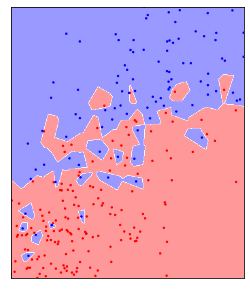

In [21]:
import sys
sys.path.append("..")
from utils import plot_2d_classification

fig, ax = plt.subplots(figsize=(5, 5))
clf = KNeighborsClassifier(n_neighbors=1).fit(X_train[['mean compactness', 'worst concave points']], y_train)
ax.scatter(X_train['mean compactness'], X_train['worst concave points'], c=y_train, cmap='bwr', s=2)
plot_2d_classification(clf, np.array(X_train[['mean compactness', 'worst concave points']]), ax=ax, alpha=.4, cmap='bwr')
ax.set_aspect("equal")
ax.set_xlim(0.05, 0.17)
ax.set_ylim(0.06, 0.2)

Here, all the points in the plane shaded as red would be classified as belonging to the red class by the KNeighborsClassifier, while all the points shaded as blue would be classfied as belonging to the blue class.
You can see that using a single nearest neighbor resultsin each point creating a small island of its class around itself, so even a red point among a lot of blue points will create a little area of red around itself where any test point would be classified as red.

Now let's see what happens if we change the number of neighbors:

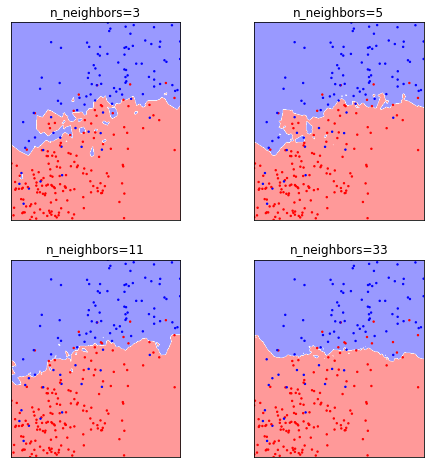

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, n_neighbors in zip(axes.ravel(), [3, 5, 11, 33]):
    ax.set_title(f"n_neighbors={n_neighbors}")
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train[['mean compactness', 'worst concave points']], y_train)
    ax.scatter(X_train['mean compactness'], X_train['worst concave points'], c=y_train, cmap='bwr', s=2)
    plot_2d_classification(clf, np.array(X_train[['mean compactness', 'worst concave points']]), ax=ax, alpha=.4, cmap='bwr')
    ax.set_aspect("equal")
    ax.set_xlim(0.05, 0.17)
    ax.set_ylim(0.06, 0.2)

You can see that as we increase the number of neighbors, some of the small 'islands' dissappear, and a smother, global picture emerges. While there is still a lot of zig-zagging in the decision boundary for three neighbors, it's mostly gone for 33 neighbors, and by then is mostly a horizontal line.
We can also see that for a low number of neighbors, most of the training samples are classified correctly, i.e. blue training samples are on a blue backdrop, while red training samples are on a red backdrop.
However, that is no longer true for 11 or 33 neighbors.

The number of neighbors here shows behavior that's very typical for hyper-parameters in machine learning, in that it is a way to control the flexibility, or complexity of the model. For one or three neighbors, the model has a very complex 'explanation' for the data, containing lots of nooks and crannies, that explain the training data well, but might not accurately represent an overall pattern. Using a larger number of neighbors results in a more global picture, in a sense a simpler explanation, which explains less of the specific cases in the training set, but which we might expect will be more generalizable.

```{admonition} Mathematical background
There is various ways to define model complexity or model flexibility rigorously, and it's one of the main ideas in theoretical machine learning.
Using Rademacher complexity TODO really? we could show that one nearest neighbors is actually more flexible than 5 nearest neighbors, though complexity measures
are much more a theoretical tool than a practical one.

Another potential theoretical view of this is in terms of model bias and model variance. We will revisit these later.
Both of these terms look at the model prediction as a function of the sample of the training data from the model distribution.
That means that we look at the variance of the prediction over potential draws of the training data, i.e. how different would
the model look if we had observed a different training set drawn from the same distribution.

In short, model with high bias is one that is systematically wrong, perhaps because the model is too simple.
A model with high variance is one where the prediction on a new datapoint depends strongly on which data was seen during training.
If a model is very flexible, it might focus very closely on particular aspects of the training data and therefore have high variance.
```